# Imports

In [41]:
import pandas as pd
import numpy as np
import opendatasets as od
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# plt.close("all")

import seaborn as sns
from tqdm import tqdm

from itertools import combinations

from flaml import AutoML

%matplotlib widget
%matplotlib inline

import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier


pd.set_option("display.max_columns", 500)
plt.style.use("dark_background")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Import Data

In [42]:
od.download("https://www.kaggle.com/competitions/titanic/data?select=train.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  d


Your Kaggle Key:

  ········


ApiException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Content-Length': '0', 'Date': 'Mon, 27 Mar 2023 15:35:31 GMT', 'Access-Control-Allow-Credentials': 'true', 'Set-Cookie': 'ka_sessionid=6f9de378421340914f1849e338508edd; max-age=2626560; path=/, GCLB=CNeY8-ui4_OSBA; path=/; HttpOnly', 'Turbolinks-Location': 'https://www.kaggle.com/api/v1/competitions/data/download-all/titanic', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-VXfoO9UfZRfU4uxEVTBM+Q==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://form.jotform.com https://submit.jotform.us https://submit.jotformpro.com https://submit.jotform.com https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kaggle-static-staging.storage.googleapis.com https://kkb-dev.jupyter-proxy.kaggle.net https://kkb-staging.jupyter-proxy.kaggle.net https://kkb-production.jupyter-proxy.kaggle.net https://kkb-dev.firebaseapp.com https://kkb-staging.firebaseapp.com https://kkb-production.firebaseapp.com https://kaggle-metastore-test.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})


In [ ]:
od.download(
    "https://www.kaggle.com/datasets/nehaprabhavalkar/av-healthcare-analytics-ii"
)# Load Data

# Helpful Functions

In [43]:
def get_first_name(string):
    return string.split()[2]


def len_of_string(string):
    return len(string)


def get_last_name(string):
    return string.split()[0][:-1]


def first_let_first_name(string):
    return string[0][0]


def letter_to_pos_in_alph(old):
    if len(old) != 1:
        return 0
    new = ord(old)
    if 65 <= new <= 90:
        # Upper case letter
        return new - 64
    elif 97 <= new <= 122:
        # Lower case letter
        return new - 96
    # Unrecognized character
    return 0

# Load Data

In [44]:
df = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/train.csv")

# Start analysis

% of men that survived

In [45]:
df.query(f"Sex == 'male'").Survived.sum() / len(df.query(f"Sex == 'male'"))

0.18890814558058924

% of women that survived

In [46]:
df.query(f"Sex == 'female'").Survived.sum() / len(df.query(f"Sex == 'female'"))

0.7420382165605095

number of people in each class

In [47]:
df["Pclass"].value_counts().sort_index().plot(kind="bar")

<Axes: title={'center': 'scatter plot of age and fare colored by survival'}, xlabel='Age', ylabel='Fare'>

survival rate by each class

In [52]:
first_class_survived = df.query("Pclass == 1").Survived.sum() / len(
    df.query("Pclass == 1")
)
second_class_survived = df.query("Pclass == 2").Survived.sum() / len(
    df.query("Pclass == 2")
)
third_class_survived = df.query("Pclass == 3").Survived.sum() / len(
    df.query("Pclass == 3")
)

class_survival = {
    1: first_class_survived,
    2: second_class_survived,
    3: third_class_survived,
}

In [53]:
# pd.DataFrame.from_dict(class_survival, orient="index").plot(kind="bar")

<Axes: title={'center': 'scatter plot of age and fare colored by survival'}, xlabel='Age', ylabel='Fare'>

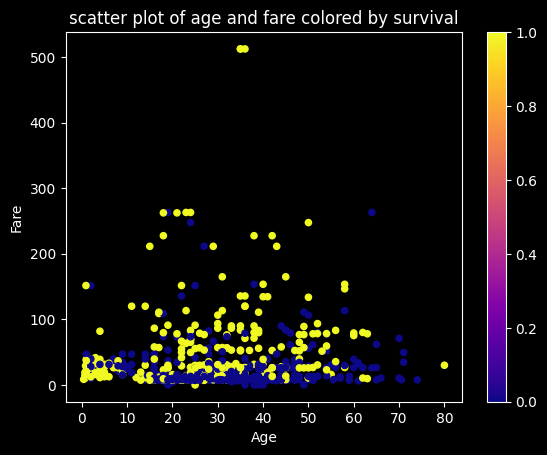

In [54]:
df[["Age", "Fare"]].plot(
    kind="scatter",
    x="Age",
    y="Fare",
    c=df["Survived"],
    cmap="plasma",
    title="scatter plot of age and fare colored by survival",
)

what fare did you have to pay to have the highest chance of survival

In [55]:
survival_dict = {}
for n in range(1, 500):
    results = df.query(f"Fare > {n}")["Survived"].value_counts()
    percent_survived = results[1] / results.sum()

    survival_dict[n] = [percent_survived]

In [56]:
pd.DataFrame.from_dict(
    survival_dict, orient="index", columns=["Probability of survival"]
).plot(xlabel="Fare paid", ylabel="probability of survival")
plt.close()

In [57]:
temp = df

In [58]:
temp["Fare"] = temp["Fare"].astype("int")
temp["Age"] = temp["Age"].fillna(temp["Age"].mean()).round(2).astype("int")
temp["Sex"] = temp["Sex"].replace(["male", "female"], [0, 1])
temp["Embarked"] = temp["Embarked"].replace(["C", "Q", "S"], [0, 1, 2])

Text(0.5, 0, 'Embarked')

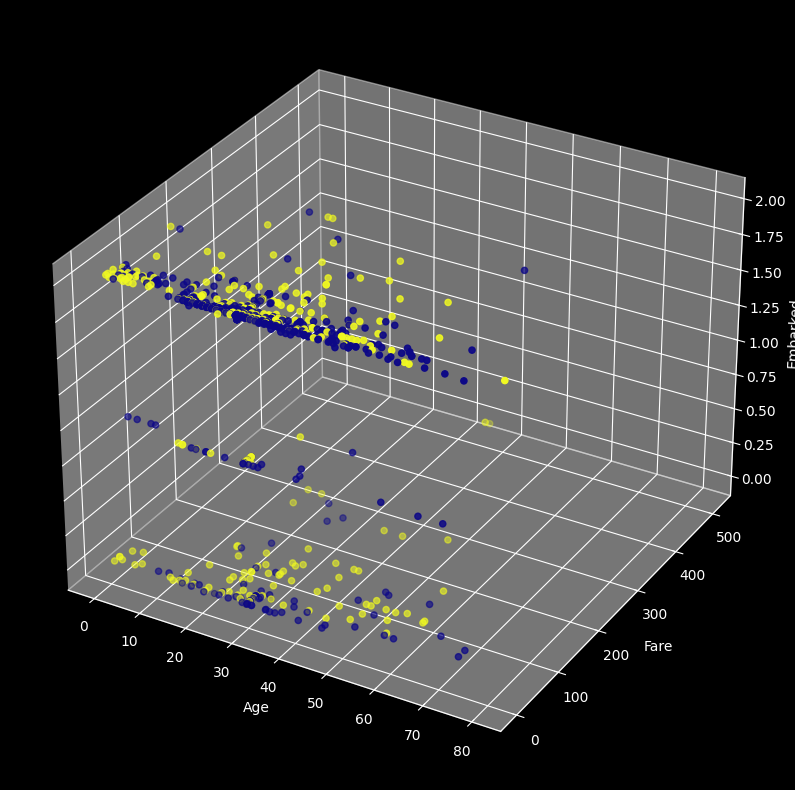

In [60]:
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(111, projection="3d")
axis.scatter(
    temp["Age"], temp["Fare"], temp["Embarked"], c=temp["Survived"], cmap="plasma"
)
axis.set_xlabel("Age", fontsize=10)
axis.set_ylabel("Fare", fontsize=10)
axis.set_zlabel("Embarked", fontsize=10)
# plt.close()

# Random Forest

In [62]:
df = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/train.csv")

In [63]:
def len_of_string(string):
    return len(string)

In [64]:
df["name_len"] = df["Name"].apply(len_of_string)
df["Age"] = df["Age"].fillna(df["Age"].mean()).round(2).astype("int")
df["Sex"] = df["Sex"].replace(["male", "female"], [0, 1])
df["Embarked"] = (
    df["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df["Fare"] = df["Fare"].astype("int")

## Determine the best features to use in the model

In [43]:
df_tree = df[
    [
        "Survived",
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "name_len",
    ]
]

In [44]:
for n in range(1, 8):
    test = SelectKBest(score_func=f_classif, k=n)
    fit = test.fit(df_tree.drop("Survived", axis=1), df_tree["Survived"])
    features_to_fit = fit.get_feature_names_out()
    features = df_tree[features_to_fit]
    target = df_tree["Survived"]
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25
    )
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"accuracy:{accuracy_score(y_test, y_pred)}")

accuracy:0.7982062780269058
accuracy:0.7892376681614349
accuracy:0.8026905829596412
accuracy:0.7802690582959642
accuracy:0.8026905829596412
accuracy:0.7892376681614349
accuracy:0.7757847533632287


In [45]:
clf_result = pd.DataFrame(clf.predict_proba(X_test))
clf_result["pred"] = y_pred
clf_result["true"] = y_test.reset_index(drop=True)

In [46]:
clf_result

,0,1,pred,true
0,0.970000,0.030000,0,0
1,0.720000,0.280000,0,0
2,0.090000,0.910000,1,0
3,0.990000,0.010000,0,0
4,0.990000,0.010000,0,0
...,...,...,...,...
218,0.927667,0.072333,0,1
219,0.960000,0.040000,0,0
220,0.990000,0.010000,0,0
221,0.890000,0.110000,0,0


In [47]:
feature_importance = pd.DataFrame.from_dict(clf.feature_importances_).T
feature_importance.columns = clf.feature_names_in_
feature_importance

,Pclass,Sex,Age,Parch,Fare,Embarked,name_len
0,0.098634,0.234646,0.199757,0.037836,0.174469,0.038877,0.21578


# Random Forest with normailized  data

In [73]:
df = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/train.csv")
df["Age"] = df["Age"].fillna(df["Age"].mean()).round(2).astype("int")
df["Sex"] = df["Sex"].replace(["male", "female"], [0, 1])
df["Embarked"] = (
    df["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df["Fare"] = df["Fare"].astype("int")
df["isalone"] = np.where((df["SibSp"] == 0) & (df["Parch"] == 0), 1, 0)
df["first_name"] = df["Name"].apply(get_first_name)
df["first_name_len"] = df["first_name"].apply(len_of_string)
df["last_name"] = df["Name"].apply(get_last_name)
df["last_name_len"] = df["last_name"].apply(len_of_string)


df = df.drop(["Ticket", "Cabin"], axis=1)

In [50]:
df_stand = df[
    [
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "isalone",
        "first_name_len",
        "last_name_len",
    ]
]

In [51]:
scaler = StandardScaler()
df_stand = pd.DataFrame(scaler.fit_transform(df_stand), columns=df_stand.columns)
df_stand["Survived"] = df["Survived"]

In [52]:
for n in range(1, len(df_stand.columns)):
    test = SelectKBest(score_func=f_classif, k=n)
    fit = test.fit(df_stand.drop("Survived", axis=1), df_stand["Survived"])
    features_to_fit = fit.get_feature_names_out()
    features = df_stand[features_to_fit]
    target = df_stand["Survived"]
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25
    )
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"accuracy:{accuracy_score(y_test, y_pred)}")

accuracy:0.7937219730941704
accuracy:0.7847533632286996
accuracy:0.8026905829596412
accuracy:0.8071748878923767
accuracy:0.8161434977578476
accuracy:0.7982062780269058
accuracy:0.7982062780269058
accuracy:0.7533632286995515
accuracy:0.8295964125560538
accuracy:0.8340807174887892


In [53]:
clf_result = pd.DataFrame(clf.predict_proba(X_test))
clf_result["pred"] = y_pred
clf_result["true"] = y_test.reset_index(drop=True)

In [54]:
clf_result

,0,1,pred,true
0,0.33,0.67,1,0
1,0.01,0.99,1,1
2,0.34,0.66,1,1
3,0.58,0.42,0,0
4,0.97,0.03,0,0
...,...,...,...,...
218,0.08,0.92,1,1
219,0.43,0.57,1,0
220,0.12,0.88,1,1
221,0.83,0.17,0,0


In [55]:
feature_importance = pd.DataFrame.from_dict(clf.feature_importances_).T
feature_importance.columns = clf.feature_names_in_
feature_importance

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isalone,first_name_len,last_name_len
0,0.088831,0.259568,0.177389,0.037459,0.028833,0.154646,0.03585,0.017318,0.091967,0.10814


# Random Forest with PCA data

In [24]:
df = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/train.csv")
df["Age"] = df["Age"].fillna(df["Age"].mean()).round(2).astype("int")
df["Sex"] = df["Sex"].replace(["male", "female"], [0, 1])
df["Embarked"] = (
    df["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df["Fare"] = df["Fare"].astype("int")
df["isalone"] = np.where((df["SibSp"] == 0) & (df["Parch"] == 0), 1, 0)
df["first_name"] = df["Name"].apply(get_first_name)
df["first_name_len"] = df["first_name"].apply(len_of_string)
df["last_name"] = df["Name"].apply(get_last_name)
df["last_name_len"] = df["last_name"].apply(len_of_string)


df = df.drop(["Ticket", "Cabin"], axis=1)

In [25]:
df_pca = df[
    [
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "isalone",
        "first_name_len",
        "last_name_len",
    ]
]

In [26]:
scaler = StandardScaler()
df_stand = pd.DataFrame(scaler.fit_transform(df_pca), columns=df_pca.columns)
# df_stand["Survived"] = df["Survived"]

In [27]:
pca = PCA(n_components=len(df_stand.columns))

In [28]:
pca.fit(df_stand)

PCA(n_components=10)

In [29]:
principal_components = pd.DataFrame(pca.components_, columns=df_stand.columns)

In [31]:
eigen_vals = pd.Series(pca.explained_variance_ratio_)

In [35]:
df_pca = pd.DataFrame(pca.transform(df_stand))

In [37]:
df_pca["Survived"] = df["Survived"]

In [49]:
features = df_pca.drop("Survived", axis=1)
target = df_pca["Survived"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"accuracy:{accuracy_score(y_test, y_pred)}")

accuracy:0.8435754189944135


# Random forest with full data

In [61]:
df_train = pd.read_csv(r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/train.csv")
df_test = pd.read_csv(r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/test.csv")

null fare in df_test @ idx 152

In [4]:
df_test["Fare"].index[df_test["Fare"].apply(np.isnan)]

Int64Index([152], dtype='int64')

In class 3, will assign mean of class 3 fare

In [5]:
df_test["Fare"][152] = df_test.query(f"Pclass == 3")["Fare"].mean()

C:\Users\Luke Chesley\AppData\Local\Temp\ipykernel_14956\2092446825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Fare"][152] = df_test.query(f"Pclass == 3")["Fare"].mean()


In [7]:
def len_of_string(string):
    return len(string)

In [8]:
df_train["name_len"] = df_train["Name"].apply(len_of_string)
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean()).round(2).astype("int")
df_train["Sex"] = df_train["Sex"].replace(["male", "female"], [0, 1])
df_train["Embarked"] = (
    df_train["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df_train["Fare"] = df_train["Fare"].astype("int")

df_test["name_len"] = df_test["Name"].apply(len_of_string)
df_test["Age"] = df_test["Age"].fillna(df_test["Age"].mean()).round(2).astype("int")
df_test["Sex"] = df_test["Sex"].replace(["male", "female"], [0, 1])
df_test["Embarked"] = (
    df_test["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df_test["Fare"] = df_test["Fare"].astype("int")

In [10]:
df_tree = df_train[
    [
        "Survived",
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "name_len",
    ]
]

In [16]:
test = SelectKBest(score_func=f_classif, k=8)
fit = test.fit(df_tree.drop("Survived", axis=1), df_tree["Survived"])
features_to_fit = fit.get_feature_names_out()
features = df_tree[features_to_fit]
target = df_tree["Survived"]
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features, target)

y_pred = clf.predict(df_test[features_to_fit])
clf_result = pd.DataFrame(clf.predict_proba(df_test[features_to_fit]))
clf_result["Survived"] = y_pred
clf_result["PassengerId"] = df_test["PassengerId"]
clf_result = clf_result[["PassengerId", "Survived", 0, 1]]

In [17]:
clf_result

,PassengerId,Survived,0,1
0,892,0,0.990000,0.010000
1,893,0,0.720000,0.280000
2,894,0,0.783881,0.216119
3,895,0,0.710000,0.290000
4,896,0,0.540000,0.460000
...,...,...,...,...
413,1305,0,0.960000,0.040000
414,1306,1,0.010000,0.990000
415,1307,0,1.000000,0.000000
416,1308,0,0.960000,0.040000


In [18]:
feature_importance = pd.DataFrame.from_dict(clf.feature_importances_).T
feature_importance.columns = clf.feature_names_in_
feature_importance

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,name_len
0,0.082465,0.233312,0.202633,0.042454,0.032653,0.157698,0.036526,0.212259


In [30]:
path = r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/"

In [31]:
final_results_sub = clf_result[["PassengerId", "Survived"]]

In [32]:
final_results_sub.to_csv(path + "titanic_sub_2.csv", index=False, encoding="utf-8")

# Auto ML

In [ ]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
automl = AutoML()
automl.fit(X_train, y_train, task="classification", metric="macro_f1", time_budget=60)
;

In [53]:
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print("Best macro_f1 on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))

print(classification_report(y_train, automl.predict(X_train)))

print(classification_report(y_test, automl.predict(X_test)))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 28, 'num_leaves': 7, 'min_child_samples': 2, 'learning_rate': 0.19269147538835465, 'log_max_bin': 9, 'colsample_bytree': 0.9803618227602316, 'reg_alpha': 0.002829276211858958, 'reg_lambda': 0.7184191782424573}
Best macro_f1 on validation data: 0.8063
Training duration of best run: 0.1008 s


              precision    recall  f1-score   support

           0       0.87      0.96      0.91       434
           1       0.92      0.77      0.84       278

    accuracy                           0.88       712
   macro avg       0.89      0.86      0.87       712
weighted avg       0.89      0.88      0.88       712



              precision    recall  f1-score   support

           0       0.85      0.91      0.88       115
           1       0.82      0.70      0.76        64

    accuracy                           0.84       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



In [57]:
preds = automl.predict(df.drop("Survived", axis=1))

In [58]:
df["automl_preds"] = preds

In [59]:
df[["Survived", "automl_preds"]]

,Survived,automl_preds
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
886,0,0
887,1,1
888,0,0
889,1,1


# AutoML with full data

In [62]:
df_train = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/train.csv")
df_test = pd.read_csv("/home/luke/jupyterlab/Datasets/titanic/test.csv")

In [63]:
df_test["Fare"].index[df_test["Fare"].apply(np.isnan)]

Int64Index([152], dtype='int64')

In [ ]:
df_test["Fare"][152] = df_test.query(f"Pclass == 3")["Fare"].mean()

In [70]:
df_test.loc[152, "Fare"] = df_test.query(f"Pclass == 3")["Fare"].mean()

In [ ]:
%%capture --no-display
X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
automl = AutoML()
automl.fit(df_train.drop("Survived", axis=1),  df_train["Survived"], task="classification", metric="macro_f1", time_budget=60,early_stop=True)

In [123]:
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print("Best macro_f1 on validation data: {0:.4g}".format(1 - automl.best_loss))
print("Training duration of best run: {0:.4g} s".format(automl.best_config_train_time))

print(classification_report(y_train, automl.predict(X_train)))

print(classification_report(y_test, automl.predict(X_test)))

Best ML leaner: xgb_limitdepth
Best hyperparmeter config: {'n_estimators': 35, 'max_depth': 4, 'min_child_weight': 0.4758021414376011, 'learning_rate': 0.19526765747155633, 'subsample': 0.989136898992892, 'colsample_bylevel': 0.9351703052369875, 'colsample_bytree': 0.9171427905839893, 'reg_alpha': 0.009487296541348228, 'reg_lambda': 0.2325359383861118}
Best macro_f1 on validation data: 0.8243
Training duration of best run: 0.1182 s
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       429
           1       0.83      0.81      0.82       283

    accuracy                           0.86       712
   macro avg       0.85      0.85      0.85       712
weighted avg       0.85      0.86      0.86       712

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       120
           1       0.74      0.85      0.79        59

    accuracy                           0.85       179
   macro avg       

In [124]:
preds = automl.predict(df_test)

In [125]:
results = pd.DataFrame(preds, columns=["Survived"])

In [126]:
results["PassengerId"] = df_test["PassengerId"]

In [79]:
path = r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/"

In [128]:
final_results_sub = results[["PassengerId", "Survived"]]

In [129]:
final_results_sub.to_csv(path + "titanic_sub_4.csv", index=False, encoding="utf-8")

# Consensus voting

In [67]:
model_1 = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/titanic_sub_1_forest.csv"
)
model_2 = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/titanic_sub_2_forest.csv"
)
model_3 = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/titanic_sub_3_autoML.csv"
)
model_4 = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/titanic_sub_4_autoML.csv"
)
concat = [model_1, model_2, model_3, model_4]

In [68]:
consen_df = pd.concat(concat, axis=1).T.drop_duplicates(keep=False).T

In [69]:
def tst(row):
    return

In [70]:
consen_df["con"] = consen_df.apply(np.sum, axis=1)

In [71]:
consen_df["fin"] = None

In [72]:
consen_df.loc[consen_df["con"] >= 3, "fin"] = 1
consen_df.loc[consen_df["con"] < 3, "fin"] = 0

In [73]:
results = pd.DataFrame(consen_df["fin"], columns=["Survived"])

In [74]:
results["PassengerId"] = df_test["PassengerId"]

In [75]:
results = results[["PassengerId", "Survived"]]

In [76]:
results["Survived"] = consen_df["fin"]

In [77]:
final_results_sub = results[["PassengerId", "Survived"]]

In [80]:
final_results_sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [78]:
final_results_sub.to_csv(
    path + "titanic_sub_5_consensus1.csv", index=False, encoding="utf-8"
)

NameError: name 'path' is not defined

# Support vector clasification

In [3]:
df = pd.read_csv(r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/train.csv")
df["Age"] = df["Age"].fillna(df["Age"].mean()).round(2).astype("int")
df["Sex"] = df["Sex"].replace(["male", "female"], [0, 1])
df["Embarked"] = (
    df["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df["Fare"] = df["Fare"].astype("int")
df["isalone"] = np.where((df["SibSp"] == 0) & (df["Parch"] == 0), 1, 0)
df["first_name"] = df["Name"].apply(get_first_name)
df["first_name_len"] = df["first_name"].apply(len_of_string)
df["last_name"] = df["Name"].apply(get_last_name)
df["last_name_len"] = df["last_name"].apply(len_of_string)
df["first_let_first_name"] = df["first_name"].apply(first_let_first_name)
df["first_let_first_name"] = df["first_let_first_name"].apply(letter_to_pos_in_alph)


df = df.drop(["Ticket", "Cabin"], axis=1)

In [56]:
df_dum = df[
    [
        "Survived",
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "isalone",
    ]
]

In [57]:
class_dum_df = pd.get_dummies(df["Pclass"], prefix="class")
embarked_dum_df = pd.get_dummies(df["Embarked"], prefix="Embarked")

In [58]:
df_dum = pd.concat([df_dum, class_dum_df], axis=1)
df_dum = pd.concat([df_dum, embarked_dum_df], axis=1)
df_dum = df_dum.drop(["Pclass", "Embarked"], axis=1)

In [59]:
scaler = StandardScaler()
df_dum_scaled = pd.DataFrame(
    scaler.fit_transform(df_dum.drop("Survived", axis=1)),
    columns=df_dum.drop("Survived", axis=1).columns,
)

In [50]:
from sklearn.svm import SVC

In [65]:
svc = SVC(C=1.5, probability=True)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dum_scaled, df_dum["Survived"], test_size=0.2
)

In [67]:
svc.fit(X_train, y_train)

SVC(C=1.5, probability=True)

In [68]:
y_pred = svc.predict(X_test)
print(f"accuracy:{accuracy_score(y_test, y_pred)}")

accuracy:0.8212290502793296


##  test data

In [51]:
df_train = pd.read_csv(r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/train.csv")
df_test = pd.read_csv(r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/test.csv")

In [52]:
df_train = df_train.drop(["Ticket", "Cabin"], axis=1)
df_test = df_test.drop(["Ticket", "Cabin"], axis=1)

In [53]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean()).round(2).astype("int")
df_train["Sex"] = df_train["Sex"].replace(["male", "female"], [0, 1])
df_train["Embarked"] = (
    df_train["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df_train["Fare"] = df_train["Fare"].astype("int")
df_train["isalone"] = np.where(
    (df_train["SibSp"] == 0) & (df_train["Parch"] == 0), 1, 0
)
df_train["first_name"] = df_train["Name"].apply(get_first_name)
df_train["first_name_len"] = df_train["first_name"].apply(len_of_string)
df_train["last_name"] = df_train["Name"].apply(get_last_name)
df_train["last_name_len"] = df_train["last_name"].apply(len_of_string)
df_train["first_let_first_name"] = df_train["first_name"].apply(first_let_first_name)
df_train["first_let_first_name"] = df_train["first_let_first_name"].apply(
    letter_to_pos_in_alph
)

In [54]:
df_test.loc[152, "Fare"] = df_test.query(f"Pclass == 3")["Fare"].mean()
df_test["Age"] = df_test["Age"].fillna(df_test["Age"].mean()).round(2).astype("int")
df_test["Sex"] = df_test["Sex"].replace(["male", "female"], [0, 1])
df_test["Embarked"] = (
    df_test["Embarked"].fillna(2).replace(["C", "Q", "S"], [0, 1, 2]).astype("int")
)
df_test["Fare"] = df_test["Fare"].astype("int")
df_test["isalone"] = np.where((df_test["SibSp"] == 0) & (df_test["Parch"] == 0), 1, 0)
df_test["first_name"] = df_test["Name"].apply(get_first_name)
df_test["first_name_len"] = df_test["first_name"].apply(len_of_string)
df_test["last_name"] = df_test["Name"].apply(get_last_name)
df_test["last_name_len"] = df_test["last_name"].apply(len_of_string)
df_test["first_let_first_name"] = df_test["first_name"].apply(first_let_first_name)
df_test["first_let_first_name"] = df_test["first_let_first_name"].apply(
    letter_to_pos_in_alph
)

In [55]:
df_dum_train = df_train[
    [
        "Survived",
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "isalone",
    ]
]
df_dum_test = df_test[
    [
        "Pclass",
        "Sex",
        "Age",
        "SibSp",
        "Parch",
        "Fare",
        "Embarked",
        "isalone",
    ]
]

In [56]:
class_dum_df_train = pd.get_dummies(df_train["Pclass"], prefix="class")
embarked_dum_df_train = pd.get_dummies(df_train["Embarked"], prefix="Embarked")

In [57]:
class_dum_df_test = pd.get_dummies(df_test["Pclass"], prefix="class")
embarked_dum_df_test = pd.get_dummies(df_test["Embarked"], prefix="Embarked")

In [58]:
df_dum_train = pd.concat([df_dum_train, class_dum_df_train], axis=1)
df_dum_train = pd.concat([df_dum_train, embarked_dum_df_train], axis=1)
df_dum_train = df_dum_train.drop(["Pclass", "Embarked"], axis=1)

In [59]:
df_dum_test = pd.concat([df_dum_test, class_dum_df_test], axis=1)
df_dum_test = pd.concat([df_dum_test, embarked_dum_df_test], axis=1)
df_dum_test = df_dum_test.drop(["Pclass", "Embarked"], axis=1)

In [60]:
scaler = StandardScaler()
df_dum_scaled_train = pd.DataFrame(
    scaler.fit_transform(df_dum_train.drop("Survived", axis=1)),
    columns=df_dum_train.drop("Survived", axis=1).columns,
)
df_dum_scaled_test = pd.DataFrame(
    scaler.fit_transform(df_dum_test),
    columns=df_dum_test.columns,
)

In [61]:
from sklearn.svm import SVC

In [62]:
svc = SVC(C=1.5, probability=True)

In [63]:
svc.fit(df_dum_scaled_train, df_dum_train["Survived"])

SVC(C=1.5, probability=True)

In [64]:
df_dum_scaled_train

,Sex,Age,SibSp,Parch,Fare,isalone,class_1,class_2,class_3,Embarked_0,Embarked_1,Embarked_2
0,-0.737695,-0.580044,0.432793,-0.473674,-0.498948,-1.231645,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838
1,1.355574,0.650112,0.432793,-0.473674,0.789405,-1.231645,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803
2,1.355574,-0.272505,-0.474545,-0.473674,-0.498948,0.811922,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838
3,1.355574,0.419458,0.432793,-0.473674,0.427056,-1.231645,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.615838
4,-0.737695,0.419458,-0.474545,-0.473674,-0.478817,0.811922,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838
...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.737695,-0.195620,-0.474545,-0.473674,-0.378164,0.811922,-0.565685,1.960202,-1.107926,-0.482043,-0.307562,0.615838
887,1.355574,-0.810699,-0.474545,-0.473674,-0.035946,0.811922,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.615838
888,1.355574,-0.041851,0.432793,2.008933,-0.176859,-1.231645,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.615838
889,-0.737695,-0.272505,-0.474545,-0.473674,-0.035946,0.811922,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.623803


In [65]:
df_dum_scaled_test

,Sex,Age,SibSp,Parch,Fare,isalone,class_1,class_2,class_3,Embarked_0,Embarked_1,Embarked_2
0,-0.755929,0.301339,-0.499470,-0.400248,-0.504190,0.807573,-0.586559,-0.534933,0.957826,-0.568142,2.843757,-1.350676
1,1.322876,1.329905,0.616992,-0.400248,-0.504190,-1.238278,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370
2,-0.755929,2.516711,-0.499470,-0.400248,-0.468341,0.807573,-0.586559,1.869391,-1.044031,-0.568142,2.843757,-1.350676
3,-0.755929,-0.252504,-0.499470,-0.400248,-0.486265,0.807573,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370
4,1.322876,-0.648106,0.616992,0.619896,-0.414569,-1.238278,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370
...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.755929,-0.015143,-0.499470,-0.400248,-0.486265,0.807573,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370
414,1.322876,0.696941,-0.499470,-0.400248,1.306142,0.807573,1.704858,-0.534933,-1.044031,1.760125,-0.351647,-1.350676
415,-0.755929,0.617821,-0.499470,-0.400248,-0.504190,0.807573,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370
416,-0.755929,-0.015143,-0.499470,-0.400248,-0.486265,0.807573,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370


In [89]:
svc_results = svc.predict(df_dum_scaled_test)
svc_results = pd.DataFrame(svc_results, columns=["Survived"])
svc_results["PassengerId"] = df_test["PassengerId"]

In [92]:
svc_results = svc_results[["PassengerId", "Survived"]]

In [93]:
path = r"C:\Users\Luke Chesley\jupyterlab/Datasets/titanic/"

In [94]:
svc_results.to_csv(path + "titanic_sub_6_svc.csv", index=False, encoding="utf-8")

In [95]:
svc_results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
